## 数据集描述

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_excel('Online_Retail.xlsx')
print(data.shape)
data.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 数据预处理

### 缺失值处理

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data['Description'].fillna('无',inplace=True)
data.dropna(subset=['CustomerID'],inplace=True)

In [5]:
data.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 异常值处理

In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### 绘制数据分布

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

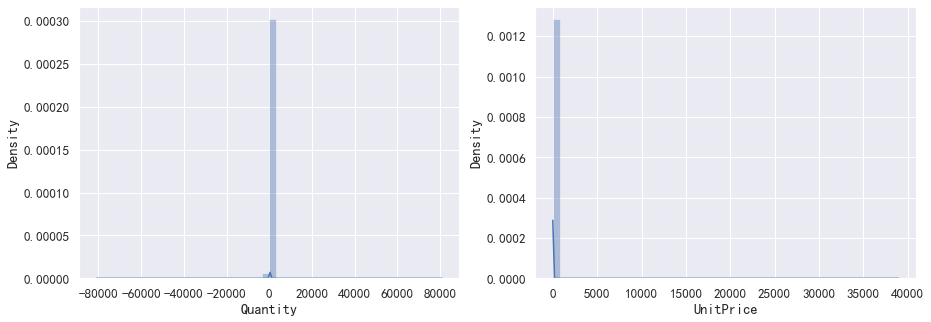

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.distplot(data['Quantity'], ax = ax[0])
sns.distplot(data['UnitPrice'], ax = ax[1])

#### 绘制箱线图

<AxesSubplot:ylabel='UnitPrice'>

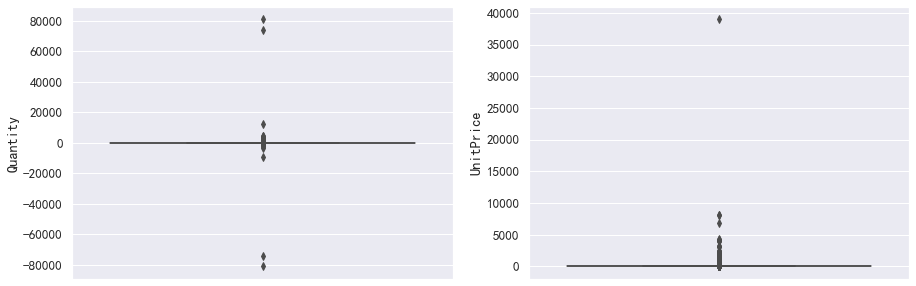

In [8]:
fig, ax  = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
sns.boxplot(y='Quantity', data = data, ax = ax[0])
sns.boxplot(y='UnitPrice', data = data, ax=ax[1])

#### 重复值处理

In [9]:
data.duplicated().sum()

5225

In [10]:
data[data.duplicated(keep=False)].sort_values(by=['InvoiceNo','StockCode']).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom


## RFM模型

### 模型概念

## 模型作用

## 程序实现

### 计算消费金额

In [11]:
data['monetory'] = data['Quantity'] * data['UnitPrice']

In [12]:
# 转换为日期类型
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# 转换为整数类型
data['CustomerID'] = data['CustomerID'].astype(np.int32)

### 构建R值

In [21]:
def build_R(group_data, current):
    # 去掉退货订单
    group_data['InvoiceNo'] = group_data['InvoiceNo'].astype(str)
    t = group_data[group_data['InvoiceNo'].str.startswith('C')==False]
    # 如果当前客户全是退货订单
    if len(t) == 0:
        # 将所有订单中最早的日期视为客户最后一次的购买日期
        delta = current - data['InvoiceDate'].min()
    else:
        # 计算当前日期与最后一次购买日期的间隔
        delta = current - t['InvoiceDate'].max()
    # 返回天数
    return delta.days

rfm = pd.DataFrame()
g = data.groupby('CustomerID')
current = pd.to_datetime('2012-01-01 00:00:00')
rfm['Recency'] = g.apply(build_R, current)
rfm.head(10)

,Recency
CustomerID,
12346,347
12347,24
12348,97
12349,40
12350,332
12352,58
12353,226
12354,254
12355,236


### 构建F值

In [23]:
def build_F(group_data):
    group_data['InvoiceNo'] = group_data['InvoiceNo'].astype(str)
    # 记录是否为退单记录
    is_refund = group_data['InvoiceNo'].str.startswith('C')
    # 获取所有的退单记录与正常记录
    normal = group_data[~is_refund]
    refund = group_data[is_refund]
    # 将正常订单数量 - 退单数量视为用户购买数量
    num = normal['InvoiceNo'].unique().shape[0] - refund['InvoiceNo'].unique().shape[0]
    # 如果订单数量小于0，则视为0
    return num if num > 0 else 0

rfm['Frequency'] = g.apply(build_F)
rfm.head(10)

,Recency,Frequency
CustomerID,,
12346,347,0
12347,24,7
12348,97,4
12349,40,1
12350,332,1
12352,58,5
12353,226,1
12354,254,1
12355,236,1


### 构建M值

In [24]:
def build_M(group_data):
    money = group_data['monetory'].sum()
    # 如果贡献金额小于0，则视为0
    return money if money > 0 else 0

rfm['Monetory'] = g.apply(build_M)
rfm.head(10)

,Recency,Frequency,Monetory
CustomerID,,,
12346,347,0,0.00
12347,24,7,4310.00
12348,97,4,1797.24
12349,40,1,1757.55
12350,332,1,334.40
12352,58,5,1545.41
12353,226,1,89.00
12354,254,1,1079.40
12355,236,1,459.40


### 客户等级评估

F:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


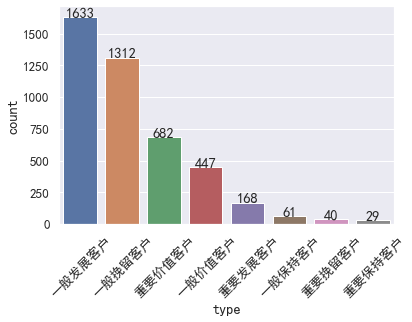

In [25]:
# 为了评估方便，R指越小价值越大，这里将R值取反处理
rfm['Recency'] *= -1
R_bar = rfm['Recency'].mean()
F_bar = rfm['Frequency'].mean()
M_bar = rfm['Monetory'].mean()

def level_evaluate(c):
    s = '重要' if c['Monetory'] >= M_bar else '一般'
    if c['Recency'] >= R_bar and c['Frequency'] >= F_bar:
        s += '价值'
    elif c['Recency'] < R_bar and c['Frequency'] >= F_bar:
        s += '保持'
    elif c['Recency'] >= R_bar and c['Frequency'] < F_bar:
        s += '发展'
    elif c['Recency'] < R_bar and c['Frequency'] < F_bar:
        s += '挽留'
    else:
        print(c)
    s += '客户'
    return s

rfm['type'] = rfm.apply(level_evaluate, axis=1)
v = rfm['type'].value_counts()
plt.xticks(rotation=45)
ax = sns.countplot(rfm['type'],order=v.index)
# 在图像上绘制数值
for x, y in enumerate(v):
    text = ax.text(x, y, y)
    # 文本数值居中对齐
    text.set_ha('center')

## RFM扩展说明

## 聚类

## 程序实现

### 数据标准化

In [26]:
# 获取Recency,Frequency与Monetory数据
X = rfm.iloc[:,:-1]
X.head()

,Recency,Frequency,Monetory
CustomerID,,,
12346,-347,0,0.00
12347,-24,7,4310.00
12348,-97,4,1797.24
12349,-40,1,1757.55
12350,-332,1,334.40


In [28]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_scale = s.fit_transform(X)
X_scale = pd.DataFrame(X_scale, columns=X.columns, index = X.index)
X_scale.head()

,Recency,Frequency,Monetory
CustomerID,,,
12346,-2.251129,-0.542685,-0.231399
12347,0.898765,0.566089,0.293102
12348,0.186869,0.090900,-0.012686
12349,0.742733,-0.384288,-0.017516
12350,-2.104849,-0.384288,-0.190705


### 确定簇数量

F:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

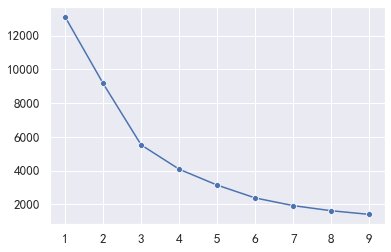

In [29]:
from sklearn.cluster import KMeans

# 定义候选的K值
scope = range(1, 10)
# 定义SSE列表，用来存放不同K值下的SSE
sse = []
for k in scope:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scale)
    sse.append(kmeans.inertia_)
plt.xticks(scope)
sns.lineplot(scope, sse, marker='o')

### 执行聚类

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scale)
# 获取聚类后的质心
print('质心：',kmeans.cluster_centers_)
# 获取每个样本所属的簇。标签的数值对应所属簇的索引
print('标签：',kmeans.labels_)
# 获取SSE（簇惯性）
print('SSE：', kmeans.inertia_)
# 获取迭代次数
print('迭代次数：', kmeans.n_iter_)
# 聚类的分值，分值越大，效果越好。直接取SSE的相反数
print('分值:', kmeans.score(X_scale))

质心： [[ 5.18762088e-01  6.40120503e-02 -4.53102594e-03]
 [-1.52486371e+00 -3.45294122e-01 -1.74431672e-01]
 [ 8.62323043e-01  9.31122712e+00  1.09906829e+01]]
标签： [1 0 0 ... 0 0 0]
SSE： 5519.688812645493
迭代次数： 7
分值: -5519.688812645493


### 数量分析

F:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


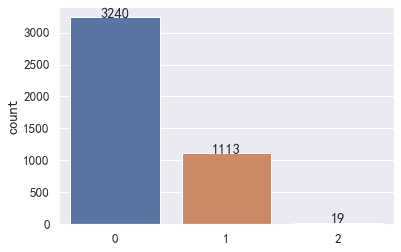

In [36]:
v= pd.Series(kmeans.labels_).value_counts()
ax = sns.countplot(kmeans.labels_, order=v.index)
# 在图像上绘制数值
for x, y in enumerate(v):
    text = ax.text(x, y, y)
    # 文本数值居中对齐
    text.set_ha('center')

### 客户群体分析

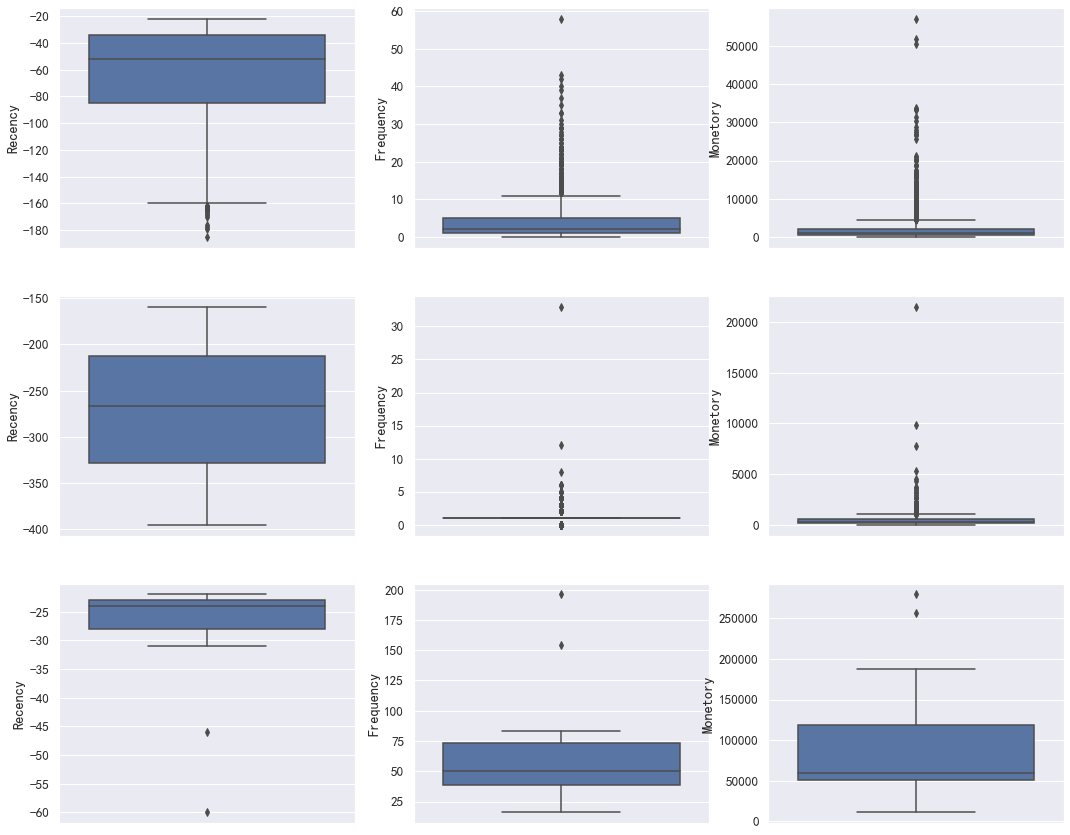

In [41]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(18, 15)
for i in range(3):
    # 获取第i个客户群的数据
    d = X[kmeans.labels_==i]
    sns.boxplot(y='Recency', data = d, ax = ax[i][0])
    sns.boxplot(y='Frequency', data = d, ax = ax[i][1])
    sns.boxplot(y='Monetory', data = d, ax = ax[i][2])

### 绘制客户群体散点图

C:\Users\zx\AppData\Local\Temp\ipykernel_8432\3313963130.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


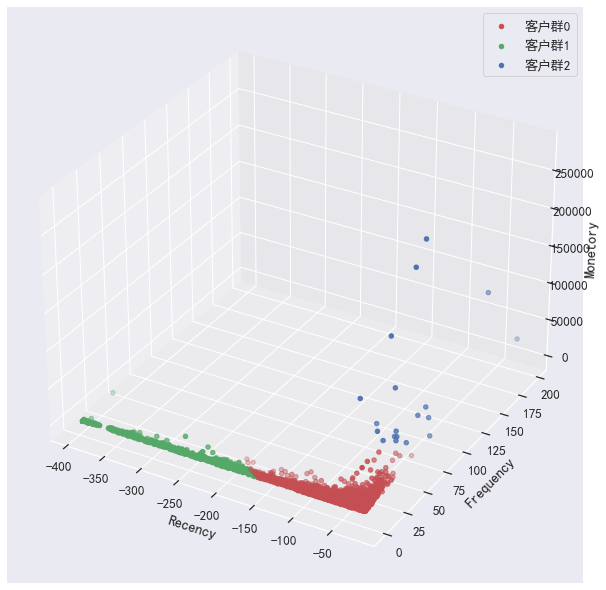

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(12, 8)
ax = Axes3D(fig)
color = ['r','g','b']
for i in range(3):
    d = X[kmeans.labels_ == i]
    ax.scatter(d['Recency'], d['Frequency'], d['Monetory'], color = color[i], label = f'客户群{i}')
ax.set_zlabel('Monetory')
ax.set_ylabel('Frequency')
ax.set_xlabel('Recency')
plt.legend()